In [1]:
library(readxl) ## Leer excel
library(tidyverse) ## Manipular base de datos
library(igraph) ## Grafos
library(expm) 
library(writexl)
library(ggraph)
library(tidygraph)  # para manipular grafos estilo tidy

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Adjuntando el paquete: 'igraph'


The following objects are masked from 'package:lubridate':

    %--%, union


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:purrr':

    compose, simplify


The following object is masked from 'package:tidyr':

    crossing


The following object is masked from 'package:tibble':

    as_data_frame


The following objects are masked from 'package:s

In [42]:
matriz <- read_excel(
    "C:/Users/cfutr/OneDrive/Escritorio/CICS/2025/Tesis/Objetivos de Aprendizaje/Modelo/Códigos para matriz/Matriz_juguete.xlsx", col_names=TRUE)

New names:
• `` -> `...1`


In [43]:
matriz_adj<-matriz%>%
  column_to_rownames(var = colnames(.)[1])%>%                         
  mutate(across(everything(), as.numeric)) %>%  
  as.matrix()

matriz_adj[is.na(matriz_adj)] <- 0

In [44]:
matriz_adj

,1,2,3,4,5
1,0,1,1,0,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,0,0,0,1
5,1,1,1,1,0


In [45]:
g <- graph_from_adjacency_matrix(matriz_adj, mode = "directed")

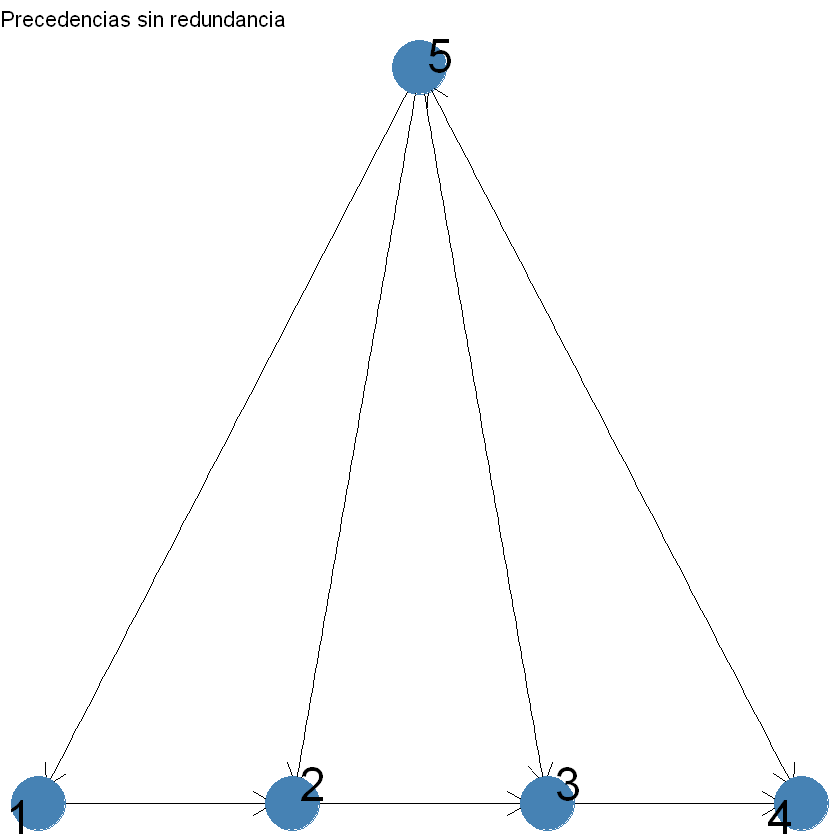

In [46]:
grafo_tidy <- as_tbl_graph(g)
# Visualizar
ggraph(grafo_tidy, layout = "tree") +
  geom_edge_link(arrow = arrow(length = unit(5, 'mm')), end_cap = circle(4, 'mm')) +
  geom_node_point(size = 15, color = "steelblue") +
  geom_node_text(aes(label = name), repel = TRUE, size = 10, max.overlaps = Inf) +
  theme_void() +
  ggtitle("Precedencias sin redundancia")

In [51]:
library(igraph)

# Suponiendo que tienes tu grafo dirigido
# g <- graph_from_adjacency_matrix(...)

# Convertimos a data.frame las aristas
aristas <- as_data_frame(g, what = "edges")

# Generamos un identificador de cada par como "A--B" ordenado alfabéticamente
aristas$pair_id <- apply(aristas[, c("from", "to")], 1, function(x) paste(sort(x), collapse = "--"))

# Contamos cuántas veces aparece cada par (si es 2, hay doble dirección)
dobles <- aristas %>%
  group_by(pair_id) %>%
  filter(n() == 2) %>%
  ungroup()

# Resultado: lista de aristas que forman relaciones bidireccionales
dobles


from,to,pair_id
<chr>,<chr>,<chr>
4,5,4--5
5,4,4--5


In [47]:
eliminar_aristas_redundantes <- function(g) {
  aristas <- as_data_frame(g, what = "edges")
  redundantes <- c()

  for (i in seq_len(nrow(aristas))) {
    from <- aristas$from[i]
    to   <- aristas$to[i]
    
    # Eliminar temporalmente la arista
    g_temp <- delete_edges(g, E(g, P = c(from, to)))

    # Comprobar si existe otra ruta de from a to
    caminos <- suppressWarnings(all_simple_paths(g_temp, from = from, to = to))
    
    # Solo marcar como redundante si hay otro camino alternativo
    if (length(caminos) > 0) {
      redundantes <- c(redundantes, i)
    }
    cat(sprintf("Revisando %d de %d: %s → %s\n", i, nrow(aristas), from, to))
  flush.console()
  }

  # Eliminar aristas redundantes del grafo original
  g_sin <- delete_edges(g, E(g)[redundantes])
  return(g_sin)
}

In [48]:
g_sin_redundancia <- eliminar_aristas_redundantes(g)

Revisando 1 de 9: 1 → 2
Revisando 2 de 9: 1 → 3
Revisando 3 de 9: 2 → 4
Revisando 4 de 9: 3 → 4
Revisando 5 de 9: 4 → 5
Revisando 6 de 9: 5 → 1
Revisando 7 de 9: 5 → 2
Revisando 8 de 9: 5 → 3
Revisando 9 de 9: 5 → 4


In [49]:
g_sin_redundancia

IGRAPH 0ff9209 DN-- 5 4 -- 
+ attr: name (v/c)
+ edges from 0ff9209 (vertex names):
[1] 2->4 3->4 4->5 5->1

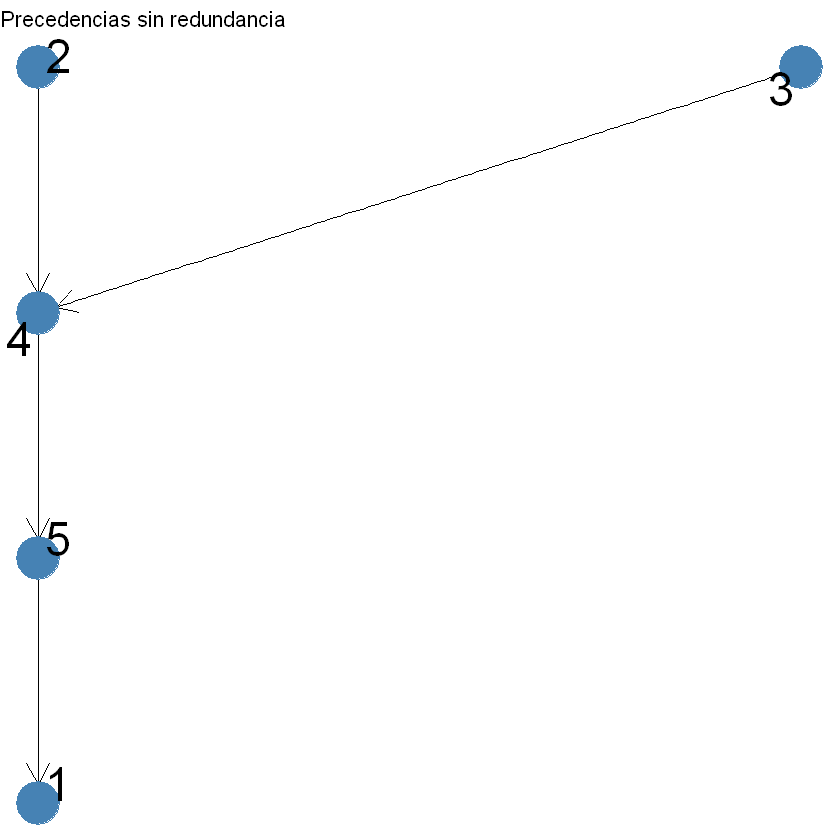

In [50]:
grafo_tidy <- as_tbl_graph(g_sin_redundancia
)
# Visualizar
ggraph(grafo_tidy, layout = "tree") +
  geom_edge_link(arrow = arrow(length = unit(5, 'mm')), end_cap = circle(4, 'mm')) +
  geom_node_point(size = 12, color = "steelblue") +
  geom_node_text(aes(label = name), repel = TRUE, size = 10, max.overlaps = Inf) +
  theme_void() +
  ggtitle("Precedencias sin redundancia")